## Linear Quadratic Regulator (LQR)
LQR is a form of optimal control that allows us to stabilize a system while minimizing the "cost" of doing so. A unique feature of LQR is that we can tune the weighting of variables in the cost function, which allows us to prioritize certain variables over others (e.g amount of fuel used vs performance).

Our cost function `J` to be minimized is given by 

![alt text](<LQR pic 1.PNG>)

`X` and `U` represent state and control actions, respectively.

We use `Q` and `R` to tune the weighting of `X` and `U`. A larger value of `Q`places a higher weighting on our state, while a larger value of `R` places a higher weighting on our control input. 

If we want the system to stabilize the system as fast as possible without much regard for the energy required to get there, we would choose a large value of `Q` and a small value of `R`.

If we want to stabilize a system using the least amount of actuator effort and we're not concerned with how long it takes, we would choose a large value of `R` and a small value of `Q`.

To begin our LQR controller design, let's create a simulation of our pendulum:

In [1]:
from pendsim import sim, controller, viz, utils
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dt, t_final = 0.01, 10
pend = sim.Pendulum(
    2.0,  # Large mass, 2.0 kg
    1.0,  # Small mass, 1.0 kg
    2.0,  # length of arm, 2.0 meter
    initial_state=np.array([0.0, 0.0, 0.0, 0.0]),
)
def force_func(t):
    return 10 * np.exp( -(  ((t-2.0)/0.1)**2) )
    #return 0
simu = sim.Simulation(dt, t_final, force_func)
# simu = sim.Simulation(dt, t_final, lambda t: 0)

Our choice of `Q` and `R` is how we "tune" our LQR controller to fit our needs.

For a 1 x n state matrix `X`, our `Q` matrix should be of form n x n

Our state matrix `X` is the 1 x 4 matrix: **[x, x_dot, theta, theta_dot]**

Then our `Q` matrix is the 4 x 4 diagonal matrix: 

![alt text](<lqr Q matrix.jpg>)

where `a`, `b`, `c`, and `d` are weighting factors for **x**, **x_dot**, **theta**, and **theta_dot** respectively

Since `U` is a scalar in our case, `R` is allowed to be a scalar too


Let's begin with an LQR controller that places a weighting of _100000_ on theta, _1000_ on theta dot, _1_ on input force, and _zero_ weighting on x or x dot. 

In [3]:
Q = np.array([[0,0,0,0], [0,0,0,0],[0,0,100000,0],[0,0,0,1000]])
R = 1
window = 10 # used in internal calculations
lqr_controller = controller.LQR(pend, dt, Q, R, window)
results = simu.simulate(pend, lqr_controller)

100%|██████████| 1000/1000 [00:00<00:00, 1156.97it/s]


Now to plot the results:

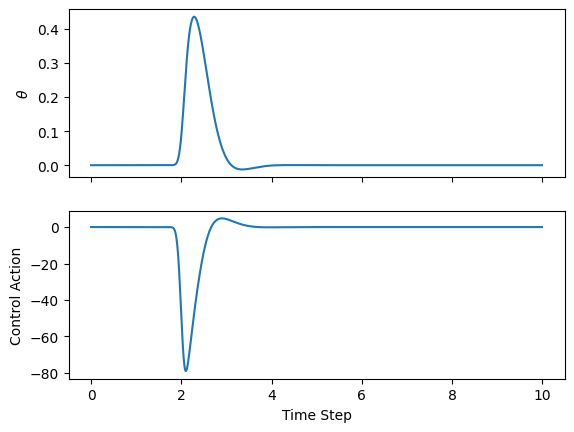

In [4]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(results[("state", "t")], label=r"$\theta$")
ax[0].set_ylabel(r"$\theta$")

ax[1].plot(results[("control action", "control action")], label="Control Action")
ax[1].set_ylabel("Control Action")
ax[1].set_xlabel("Time Step")
plt.show()

Let's look at a visualization of our LQR simulation. Note: External force is red and control force is blue.

In [ ]:
visu = viz.Visualizer(results, pend, dt=dt, speed=1)
ani = visu.animate()
from IPython.display import HTML
HTML(ani.to_html5_video())

Let's see what happens as we gradually increase `R`, meaning we increase the "punishment" of control inputs

In [ ]:
Q = np.array([[0,0,0,0], [0,0,0,0],[0,0,100000,0],[0,0,0,1000]])
R = 0
window = 10 # used in internal calculations

increase_by = 2
n = 32
conts = []
pends = [pend] * n
R_values = []
for _ in range(n):
    # increase the gain
    R += increase_by
    conts.append(controller.LQR(pend, dt, Q, R, window))
    R_values.append(R)
# simulate each controller
all_results = simu.simulate_multiple(pends, conts)

nrows, ncols = 4, 4
fig1, ax1 = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(15,12))
axn, ax_idxs = 0, {}
for i in range(nrows):
    for j in range(ncols):
        ax_idxs[axn] = (i, j)
        axn += 1
for g, (idx, res), (axi, axj) in zip(R_values, all_results.groupby(level=0), ax_idxs.values()):
    res.index = res.index.droplevel(0)
    ax1[axi, axj].plot(res[('state', 't')])
    ax1[axi, axj].set_title('R=' + str(g))
# label plots
for i in range(nrows):
    ax1[i, 0].set_ylabel('theta (rad)')
for j in range(ncols):
    ax1[-1, j].set_xlabel('time (s)')

plt.show()

Keeping `R` at _5_, let's see what happens when we vary `Q`, which increases the punishment of our state vector

In [ ]:
Q = np.array([[0,0,0,0], [0,0,0,0],[0,0,0,0],[0,0,0,0]])
R = 5
window = 10 # used in internal calculations

increase_c = 5000
increase_d = 500
n = 16
conts = []
pends = [pend] * n
Q_values = []
for _ in range(n):
    # increase the gain
    Q = Q + np.array([[0,0,0,0], [0,0,0,0],[0,0,increase_c,0],[0,0,0,increase_d]])
    conts.append(controller.LQR(pend, dt, Q, R, window))
    Q_values.append(Q)
# simulate each controller
all_results = simu.simulate_multiple(pends, conts)

nrows, ncols = 4, 4
fig1, ax1 = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(15,12))
axn, ax_idxs = 0, {}
for i in range(nrows):
    for j in range(ncols):
        ax_idxs[axn] = (i, j)
        axn += 1
for g, (idx, res), (axi, axj) in zip(Q_values, all_results.groupby(level=0), ax_idxs.values()):
    res.index = res.index.droplevel(0)
    ax1[axi, axj].plot(res[('state', 't')])
    ax1[axi, axj].set_title('C=' + str(g[2,2]) + ' and D=' + str(g[3,3]))
# label plots
for i in range(nrows):
    ax1[i, 0].set_ylabel('theta (rad)')
for j in range(ncols):
    ax1[-1, j].set_xlabel('time (s)')

plt.show()
